**Set up notebook:**

In [ ]:
#!pip install ipympl

In [ ]:
#@title Import required libraries for this notebook
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.models import model_from_json, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Input
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab import files
import seaborn as sns
from sklearn.linear_model import LinearRegression
import re
from sklearn.metrics import mean_squared_error
import math

from google.colab import output
output.enable_custom_widget_manager()

pd.set_option('display.max_rows', 200)

In [ ]:
#@title Define input source for data
i = input('Input data source. 1 -> Google Drive   2 -> Local storage: ')

if i=='1':
  #Configure Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

  #Path to dataset folder
  data_folder = '/content/drive/My Drive/MA/'

elif i=='2':
  #Upload files from local storage
  from google.colab import files

  uploaded = files.upload()
  data_folder = ''

Input data source. 1 -> Google Drive   2 -> Local storage: 1
Mounted at /content/drive


In [ ]:
#====================================================================================================================================================

**Set up helping functions**

In [ ]:
#@title get_train_test_data
def get_train_test_data(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end):
  
  train_data = dataset[train_date_start : train_date_end]

  test_data = dataset[test_date_start : test_date_end]

  return train_data, test_data

In [ ]:
#@title get_X_Y
def get_X_Y(dataset: pd.DataFrame, y_column):
  #Drop rows with NaN values
  XY = dataset.dropna()
  #Split data to X and Y
  X = XY.drop(y_column, axis=1)
  Y = XY[[y_column]]

  return X,Y

In [ ]:
#@title normalize_X_Y_train
def normalize_X_Y_train(X: pd.DataFrame, Y: pd.DataFrame):
  scaler_input = MinMaxScaler(feature_range=(0, 1))
  scaler_input = scaler_input.fit(X)

  scaler_target = MinMaxScaler(feature_range=(0, 1))
  scaler_target = scaler_target.fit(Y)

  X_normalized = pd.DataFrame(scaler_input.transform(X), columns=X.columns, index=X.index)
  Y_normalized = pd.DataFrame(scaler_target.transform(Y), columns=Y.columns, index= Y.index)

  return X_normalized, Y_normalized, scaler_input, scaler_target

In [ ]:
#@title normalize_X_Y_test
def normalize_X_Y_test(X: pd.DataFrame, Y: pd.DataFrame, scaler_input, scaler_target):
  X_normalized = pd.DataFrame(scaler_input.transform(X), columns=X.columns, index=X.index)
  Y_normalized = pd.DataFrame(scaler_target.transform(Y), columns=Y.columns, index= Y.index)

  return X_normalized, Y_normalized

In [ ]:
#@title get_trained_reg
def get_trained_reg(x: pd.DataFrame, y: pd.DataFrame):
  return LinearRegression().fit(x, y)

In [ ]:
#@title get_trained_MLP
from keras import callbacks
def get_trained_MLP(x: pd.DataFrame, y: pd.DataFrame, model=None, dense_1_shape=10, dense_2_shape=10, dense_3_shape=10, dense_4_shape=10, epochs=100, batch_size=100, verbose=2):
  #Train model further
  if model:
    model.fit(x, y, epochs=epochs, batch_size = batch_size, verbose = verbose, shuffle=False)
    return model

  #Otherwise, create new model
  model = Sequential([
            Input(x.shape[1]),
            Dense(dense_1_shape, activation='relu'),
            #sigmoid
            #regularization (L2)
            Dense(dense_2_shape, activation='relu'),
            Dense(y.shape[1])
        ])
  model.summary()

  #Compile model
  model.compile(loss='mean_squared_error', optimizer='adam')

  #Train model
  callback = EarlyStopping(monitor='loss', patience=20, mode='min', restore_best_weights=True)
  ##Initialize weights
  model.fit(x, y, epochs=epochs, batch_size = batch_size, verbose = verbose, shuffle=False, callbacks=[callback])

  return model

In [ ]:
#@title plot_predicted_vs_true
def plot_predicted_vs_true(predictions: pd.DataFrame, ground_truth: pd.DataFrame, y_column, hue=None, x_column='index', figsize=(25, 7)):

  #predictions = predictions.rename(columns={y_column : y_column + '_pred'})
  #ground_truth = ground_truth.rename(columns={y_column : y_column + '_true'})
  fig, ax = plt.subplots(figsize=figsize)
  if hue:
    ax.plot(getattr(ground_truth[ground_truth[hue] == False], x_column), ground_truth[ground_truth[hue] == False][y_column], label='Measured signal (not {})'.format(hue), color='blue', marker='o')
    ax.scatter(getattr(ground_truth[ground_truth[hue] == True], x_column), ground_truth[ground_truth[hue] == True][y_column], label='Measured signal ({})'.format(hue), color='darkred', marker='x', s=100)
  else:
    ax.plot(getattr(ground_truth, x_column), ground_truth[y_column], label='Measured signal', color='blue', marker='o')

  ax.plot(getattr(predictions, x_column), predictions[y_column], label='Simulation', color='green')

  ax.grid(True)

  ax.legend()
  ax.set_xlabel('Timestamp')
  ax.set_ylabel( y_column + ' [0C]')

  '''
  df = predictions.join(ground_truth)

  fig = plt.figure(figsize=(25,7))
  sns.lineplot(data=df)
  '''
  '''
  fig, ax = plt.subplots(figsize=(25,7))
  ax.plot(ground_truth.index, ground_truth[y_column], color = 'green')
  ax.plot(predictions.index, predictions[y_column], color = 'blue')

  ax.grid(True)

  ax.legend(['Ground Truth', 'Simulation'])
  ax.set_xlabel('Timestamp')
  ax.set_ylabel(y_column + ' [0C]')
  '''

In [ ]:
#@title plot_error
def plot_error(predictions: pd.DataFrame, ground_truth: pd.DataFrame, y_column):
  fig, ax = plt.subplots(figsize=(25,7))
  errors = ((ground_truth[y_column] - predictions[y_column] ) / ground_truth[y_column]) * 100
  ax.plot(errors, color = 'red')

  ax.grid(True)

  ax.set_xlabel('Timestamp')
  ax.set_ylabel('Error [%]')

  return pd.DataFrame(errors)

In [ ]:
#@title implement_pipeline_reg
def implement_pipeline_reg(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end, y_column, turbine_id=None, features=None):
  if turbine_id:
    dataset = dataset[dataset.Turbine_ID == turbine_id]
  if features:
    dataset = dataset[features]

  #Split dataset to training and test
  train_data, test_data = get_train_test_data(dataset, train_date_start, train_date_end, test_date_start, test_date_end)
  
  #X-Y split
  X_train, Y_train = get_X_Y(train_data, y_column)
  X_test, Y_test = get_X_Y(test_data, y_column)
  
  #Normalize data
  #x_train, y_train, scaler_input, scaler_target = normalize_X_Y_train(X_train, Y_train)
  
  #Train model
  print('Training model...')
  model = get_trained_reg(X_train, Y_train)

  #Calculate errors
  predictions_train = pd.DataFrame(model.predict(X_train), columns=Y_train.columns, index=X_train.index)
  errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

  predictions_test = pd.DataFrame(model.predict(X_test), columns=Y_test.columns, index=X_test.index)
  errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

  #Evaluate model
  #x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)
  print('Evaluating model...')
  # print('Score for training data: ', model.score(X_train, Y_train))
  # print('Score for test data: ', model.score(X_test, Y_test))
  print('RMSE Train: ', math.sqrt(mean_squared_error(Y_train[y_column], predictions_train[y_column])))
  print('RMSE Test: ', math.sqrt(mean_squared_error(Y_test[y_column], predictions_test[y_column])))

  return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model


In [ ]:
#@title implement_pipeline_mlp
def implement_pipeline_mlp(dataset: pd.DataFrame, train_date_start, train_date_end, test_date_start, test_date_end, y_column, turbine_id=None, features=None,
                           model=None, dense_1_shape=32, dense_9_shape=16, epochs=10, batch_size=100, verbose=2, normalize=False):
  if turbine_id:
    dataset = dataset[dataset.Turbine_ID == turbine_id]
  if features:
    dataset = dataset[features]

  #Split dataset to training and test
  train_data, test_data = get_train_test_data(dataset, train_date_start, train_date_end, test_date_start, test_date_end)
  
  #X-Y split
  X_train, Y_train = get_X_Y(train_data, y_column)
  X_test, Y_test = get_X_Y(test_data, y_column)
  
  if normalize:
    #Normalize data
    x_train, y_train, scaler_input, scaler_target = normalize_X_Y_train(X_train, Y_train)
    
    #Train model
    print('Training model...')
    model = get_trained_MLP(x_train, y_train, epochs=epochs)

    x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)

    #Calculate errors
    predictions_train = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_train)), columns=Y_train.columns, index=x_train.index)
    errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

    predictions_test = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_test)), columns=Y_test.columns, index=x_test.index)
    errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

    #Evaluate model
    #x_test, y_test = normalize_X_Y_test(X_test, Y_test, scaler_input, scaler_target)
    print('Evaluating model...')
    # print('Score for training data: ', model.score(X_train, Y_train))
    # print('Score for test data: ', model.score(X_test, Y_test))
    print('RMSE Train: ', math.sqrt(mean_squared_error(Y_train[y_column], predictions_train[y_column])))
    print('RMSE Test: ', math.sqrt(mean_squared_error(Y_test[y_column], predictions_test[y_column])))

    return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model, scaler_input, scaler_target


  else:
    #Train model
    print('Training model...')
    model = get_trained_MLP(X_train, Y_train, epochs=epochs)

    #Evaluate model
    print('Evaluating model...')
    print('Score for training data: ', model.evaluate(X_train, Y_train))
    print('Score for test data: ', model.evaluate(X_test, Y_test))

    #Calculate errors
    predictions_train = pd.DataFrame(model.predict(X_train), columns=Y_train.columns, index=X_train.index)
    #predictions_train = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_train)), columns=Y_train.columns, index=x_train.index)
    errors_train = pd.DataFrame(Y_train[y_column] - predictions_train[y_column])

    predictions_test = pd.DataFrame(model.predict(X_test), columns=Y_test.columns, index=X_test.index)
    #predictions_test = pd.DataFrame(scaler_target.inverse_transform(model.predict(x_test)), columns=Y_test.columns, index=x_test.index)
    errors_test = pd.DataFrame(Y_test[y_column] - predictions_test[y_column])

    return dataset, X_train, Y_train, predictions_train, errors_train, X_test, Y_test, predictions_test, errors_test, model

  


In [ ]:
#@title remove_duplicates
def remove_duplicates(list_with_duplicates):
    return list(dict.fromkeys(list_with_duplicates))

In [ ]:
#@title kl_divergence
def kl_divergence(p, q):
  epsilon = 1e-10
  p += epsilon
  q += epsilon
  return np.sum(p * np.log(p / q))

In [ ]:
#@title get_log_feature
def get_log_feature(logs: pd.DataFrame, log_msg_column, string_query):
  filtered_logs = logs[logs[log_msg_column].str.contains(string_query).fillna(False)]
  index = filtered_logs.index.name
  filtered_logs = filtered_logs.reset_index().drop_duplicates().set_index(index)

  log_feature = filtered_logs[log_msg_column].str.findall(string_query + ' *(\d)*').apply(lambda row: int(row[0]))

  return log_feature

In [ ]:
#@title append_relevant_log_warnings
def append_relevant_log_warnings(Y: pd.DataFrame, logs: pd.DataFrame, log_msg_column, target_feature_name, filter_by=None, max_distance='24H'):
  relevant_logs = logs[logs[log_msg_column].str.contains(target_feature_name.split('_Temp')[0].replace('_', ' '), na=False, case=False)]

  Y['logs_found'] = None
  for index, row in Y[Y[filter_by]].iterrows() if filter_by else Y.iterrows():
    filtered_logs = relevant_logs[(index - pd.Timedelta(max_distance)) : index]
    if not filtered_logs.empty:
      string = ''
      for i, r in filtered_logs.iterrows():
        string = string + r[log_msg_column] + ' @ ' + str(i) + '\n '
      Y.loc[index, 'logs_found'] = string

    else:
      Y.loc[index, 'logs_found'] = 'No logs found'
    
  return Y

In [ ]:
#@title plot_log_warnings
def plot_log_warnings(gt: pd.DataFrame, anomaly_column_name, log_column_name, target_feature, replacement_message = ' '):
  last_logs_found = ''
  for line in range(0, gt.shape[0], 1):
    if gt[anomaly_column_name][line] and gt[log_column_name][line] != last_logs_found:
      plt.text(gt.index[line], gt[target_feature][line], gt[log_column_name][line], size='small', color='black', weight='semibold', rotation=30)
      last_logs_found = gt[log_column_name][line]

    elif gt[log_column_name][line] == replacement_message:
        plt.text(gt.index[line], gt[target_feature][line], '!!{}!!'.format(replacement_message), size='medium', color='darkred', weight='bold', rotation=30)

In [ ]:
#@title plot_control_signals
def plot_control_signals(x: pd.DataFrame, log_feature_name):
  last_value = -1
  for ix, row in x.iterrows():
    if str(row[log_feature_name]) == 'nan':
      plt.axvline(x=ix, linestyle='-', color='grey', label='Day Separator')
      last_value = -1
    if row[log_feature_name] != last_value:
      if row[log_feature_name] == 0.0:
        plt.axvline(x=ix, linestyle='--', color='darkred', label='{} 0'.format(log_feature_name))
      elif row[log_feature_name] == 1:
        plt.axvline(x=ix, linestyle='--', color='green', label='{} 1'.format(log_feature_name))
      elif row[log_feature_name] == 2:
        plt.axvline(x=ix, linestyle='--', color='black', label='{} 2'.format(log_feature_name))
      
      last_value=row[log_feature_name]

**Data preprocessing...**

**Load dataset:**

In [ ]:
#Read WTG data
signals = 'wind-farm-1-signals-training.csv'
signals_test = 'wind-farm-1-signals-testing.csv'

#Read Signals data for all turbines and set timestamp as index
all_data = pd.concat([pd.read_csv(data_folder + signals, delimiter=';'), pd.read_csv(data_folder + signals_test, delimiter=';')], ignore_index=True)
all_data['Timestamp'] = pd.to_datetime(all_data['Timestamp'])
all_data.set_index('Timestamp', inplace=True)


#Read log data
logs = 'wind-farm-1-logs-training.csv'
logs_test = 'wind-farm-1-logs-testing.csv'

#Read logs from all turbines and set TimeDetected as index
log_data = pd.concat([pd.read_csv(data_folder + logs, delimiter=';'), pd.read_csv(data_folder + logs_test, delimiter=';')], ignore_index=True)
log_data['TimeDetected'] = pd.to_datetime(log_data['TimeDetected'])
log_data.set_index('TimeDetected', inplace=True)

#Target/Test turbine: Filter T_09 data out
T09_data = all_data[all_data.Turbine_ID == 'T09']
log_data_T09 = log_data[log_data['UnitTitle'] == 'T09']

#Reference/Validation turbine: Filter T_01 data out
T01_data = all_data[all_data.Turbine_ID == 'T01']
log_data_T01 = log_data[log_data['UnitTitle'] == 'T01']

#Remove duplicates in Timestamp index: Usually occurs at daylight saving
T09_data = T09_data[~T09_data.index.duplicated(keep='first')]
T01_data = T01_data[~T01_data.index.duplicated(keep='first')]

**Extract log feature:**

In [ ]:
#Internal vent
logs_int_T09 = get_log_feature(log_data_T09, 'Remark', 'Gen. int. vent.')
logs_int_T01 = get_log_feature(log_data_T01, 'Remark', 'Gen. int. vent.')

#External vent
logs_ext_T09 = get_log_feature(log_data_T09, 'Remark', 'Gen. ext. vent.')
logs_ext_T01 = get_log_feature(log_data_T01, 'Remark', 'Gen. ext. vent.')

**Append log feature to signals:**

In [ ]:
#Internal vent
T09_data_logs = pd.merge_asof(T09_data, logs_int_T09, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='bfill').rename(columns={'Remark' : 'Int_Vent'})
T01_data_logs = pd.merge_asof(T01_data, logs_int_T01, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='bfill').rename(columns={'Remark' : 'Int_Vent'})

#External vent
T09_data_logs = pd.merge_asof(T09_data_logs, logs_ext_T09, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='bfill').rename(columns={'Remark' : 'Ext_Vent'})
T01_data_logs = pd.merge_asof(T01_data_logs, logs_ext_T01, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='bfill').rename(columns={'Remark' : 'Ext_Vent'})

**EDA...**

In [ ]:
#Selected features
features_w_logs = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Prod_LatestAvg_TotActPwr', 'Gen_Bear_Temp_Avg', 'Int_Vent', 'Ext_Vent']
features_wout_logs = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Prod_LatestAvg_TotActPwr', 'Gen_Bear_Temp_Avg']
target_feature = 'Gen_Bear_Temp_Avg'

#Train/Test Periods
train_start_T09 = '2016-01-01'
train_end_T09 = '2016-02-15'
test_start_T09 = '2016-02-16'
test_end_T09 = '2016-10-18'

train_start_T01 = '2016-09-01'
train_end_T01 = '2016-12-31'
test_start_T01 = '2017-01-01'
test_end_T01 = '2017-12-31'

T09_data_logs.loc[train_start_T09 : train_end_T09, 'dataset'] = 'Train'
T09_data_logs.loc[test_start_T09 : test_end_T09, 'dataset'] = 'Test'

T01_data_logs.loc[train_start_T01 : train_end_T01, 'dataset'] = 'Train'
T01_data_logs.loc[test_start_T01 : test_end_T01, 'dataset'] = 'Test'

Distribution of Features (T09)

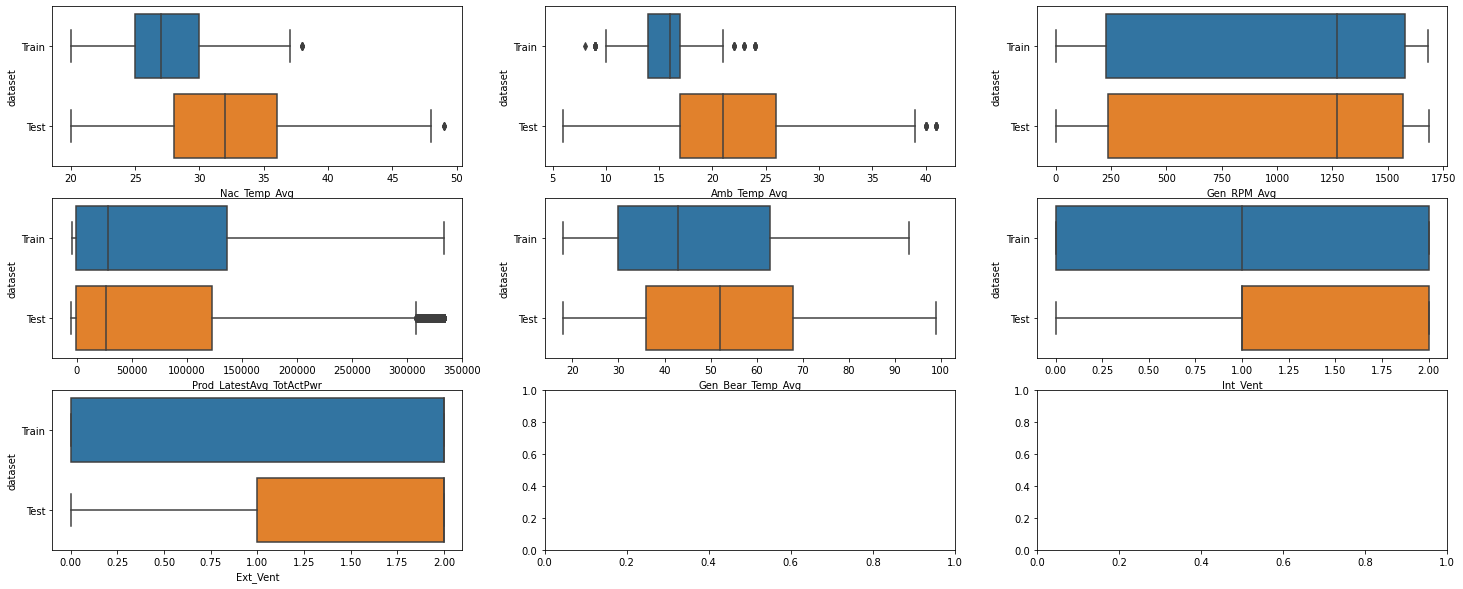

In [ ]:
%matplotlib inline
fig, axes = plt.subplots((len(features_w_logs)//3) + 1, 3, figsize=(25,10))
for (i, feature) in zip(range(len(features_w_logs)), features_w_logs):
  sns.boxplot(data = T09_data_logs, x=feature, y='dataset', ax=axes[i//3][i%3])

Distribution of Features (T01)

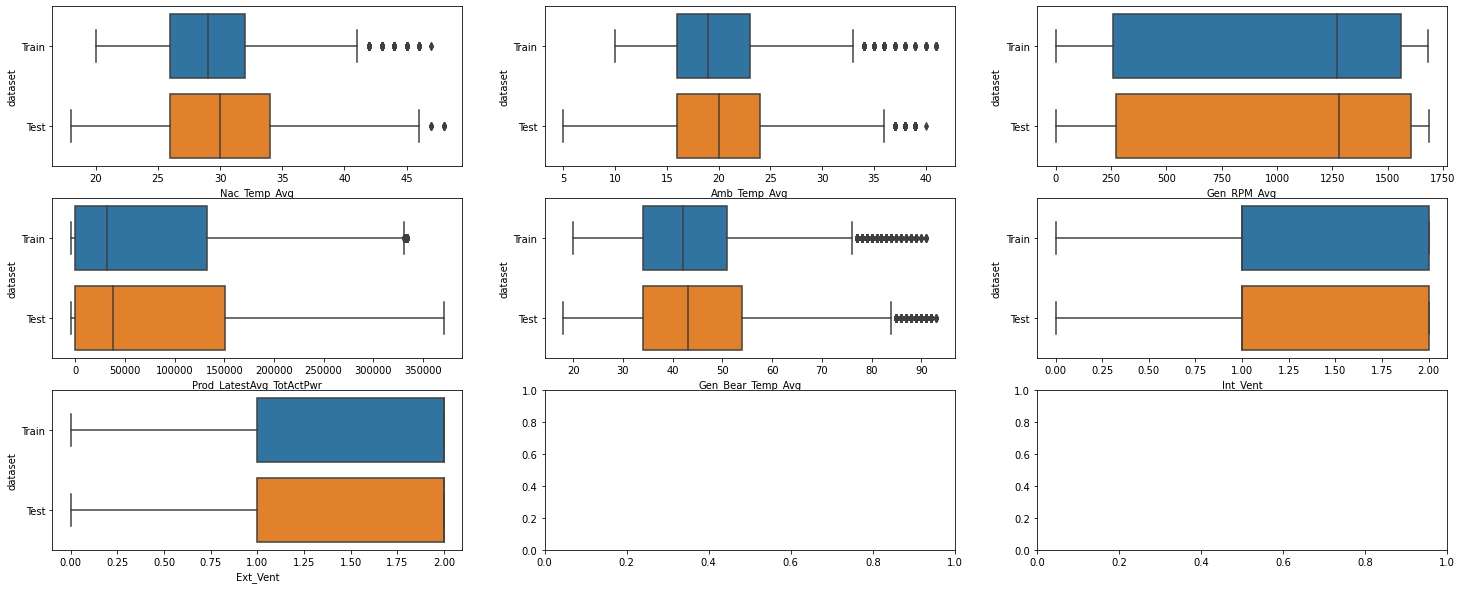

In [ ]:
%matplotlib inline
fig, axes = plt.subplots((len(features_w_logs)//3) + 1, 3, figsize=(25,10))
for (i, feature) in zip(range(len(features_w_logs)), features_w_logs):
  sns.boxplot(data = T01_data_logs, x=feature, y='dataset', ax=axes[i//3][i%3])

Correlation of log features with target feature

In [ ]:
dic = [{'turbine' : 'T09', 
        'Int_Vent' : T09_data_logs[train_start_T09 : train_end_T09][['Int_Vent']].corrwith(T09_data_logs[train_start_T09 : train_end_T09][target_feature])['Int_Vent'],
        'Ext_Vent' : T09_data_logs[train_start_T09 : train_end_T09][['Ext_Vent']].corrwith(T09_data_logs[train_start_T09 : train_end_T09][target_feature])['Ext_Vent'],
        'dataset' : 'Train'},
       {'turbine' : 'T09', 
        'Int_Vent' : T09_data_logs[test_start_T09 : test_end_T09][['Int_Vent']].corrwith(T09_data_logs[test_start_T09 : test_end_T09][target_feature])['Int_Vent'],
        'Ext_Vent' : T09_data_logs[test_start_T09 : test_end_T09][['Ext_Vent']].corrwith(T09_data_logs[test_start_T09 : test_end_T09][target_feature])['Ext_Vent'],
        'dataset' : 'Test'},
       {'turbine' : 'T01', 
        'Int_Vent' : T01_data_logs[train_start_T01 : train_end_T01][['Int_Vent']].corrwith(T01_data_logs[train_start_T01 : train_end_T01][target_feature])['Int_Vent'],
        'Ext_Vent' : T01_data_logs[train_start_T01 : train_end_T01][['Ext_Vent']].corrwith(T01_data_logs[train_start_T01 : train_end_T01][target_feature])['Ext_Vent'],
        'dataset' : 'Train'},
       {'turbine' : 'T01', 
        'Int_Vent' : T01_data_logs[test_start_T01 : test_end_T01][['Int_Vent']].corrwith(T01_data_logs[test_start_T01 : test_end_T01][target_feature])['Int_Vent'],
        'Ext_Vent' : T01_data_logs[test_start_T01 : test_end_T01][['Ext_Vent']].corrwith(T01_data_logs[test_start_T01 : test_end_T01][target_feature])['Ext_Vent'],
        'dataset' : 'Test'}]

corr = pd.DataFrame(dic).set_index('turbine')
corr

Int_Vent  Ext_Vent dataset
turbine                            
T09      0.810796  0.793037   Train
T09      0.803704  0.775171    Test
T01      0.774505  0.729883   Train
T01      0.768904  0.725776    Test

**NBM for T09(Faulty turbine)**

**Deep Learning**

In [ ]:
#Train with log features
dataset_9, X_train_9, Y_train_9, predictions_train_9, errors_train_9, X_test_9, Y_test_9, predictions_test_9, errors_test_9, model_9, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T09_data_logs, train_date_start = train_start_T09, train_date_end = train_end_T09,
                                           test_date_start = test_start_T09, test_date_end = test_end_T09, y_column = target_feature, turbine_id='T09',
                         features=features_w_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                70        
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
67/67 - 1s - loss: 0.0429 - 646ms/epoch - 10ms/step
Epoch 2/300
67/67 - 0s - loss: 0.0196 - 146ms/epoch - 2ms/step
Epoch 3/300
67/67 - 0s - loss: 0.0192 - 137ms/epoch - 2ms/step
Epoch 4/300
67/67 - 0s - loss: 0.0189 - 188ms/epoch - 3ms/step
Epoch 5/300
67/67 - 0s - loss: 0.0186 - 131ms/epo

In [ ]:
#Train without log features
dataset_9_x, X_train_9_x, Y_train_9_x, predictions_train_9_x, errors_train_9_x, X_test_9_x, Y_test_9_x, predictions_test_9_x, errors_test_9_x, model_9_x, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T09_data_logs, train_date_start = train_start_T09, train_date_end = train_end_T09,
                                           test_date_start = test_start_T09, test_date_end = test_end_T09, y_column = target_feature, turbine_id='T09',
                         features=features_wout_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                50        
                                                                 
 dense_10 (Dense)            (None, 10)                110       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
67/67 - 1s - loss: 0.1679 - 573ms/epoch - 9ms/step
Epoch 2/300
67/67 - 0s - loss: 0.0518 - 105ms/epoch - 2ms/step
Epoch 3/300
67/67 - 0s - loss: 0.0278 - 117ms/epoch - 2ms/step
Epoch 4/300
67/67 - 0s - loss: 0.0255 - 113ms/epoch - 2ms/step
Epoch 5/300
67/67 - 0s - loss: 0.0228 - 111ms/epoc

Distribution of errors

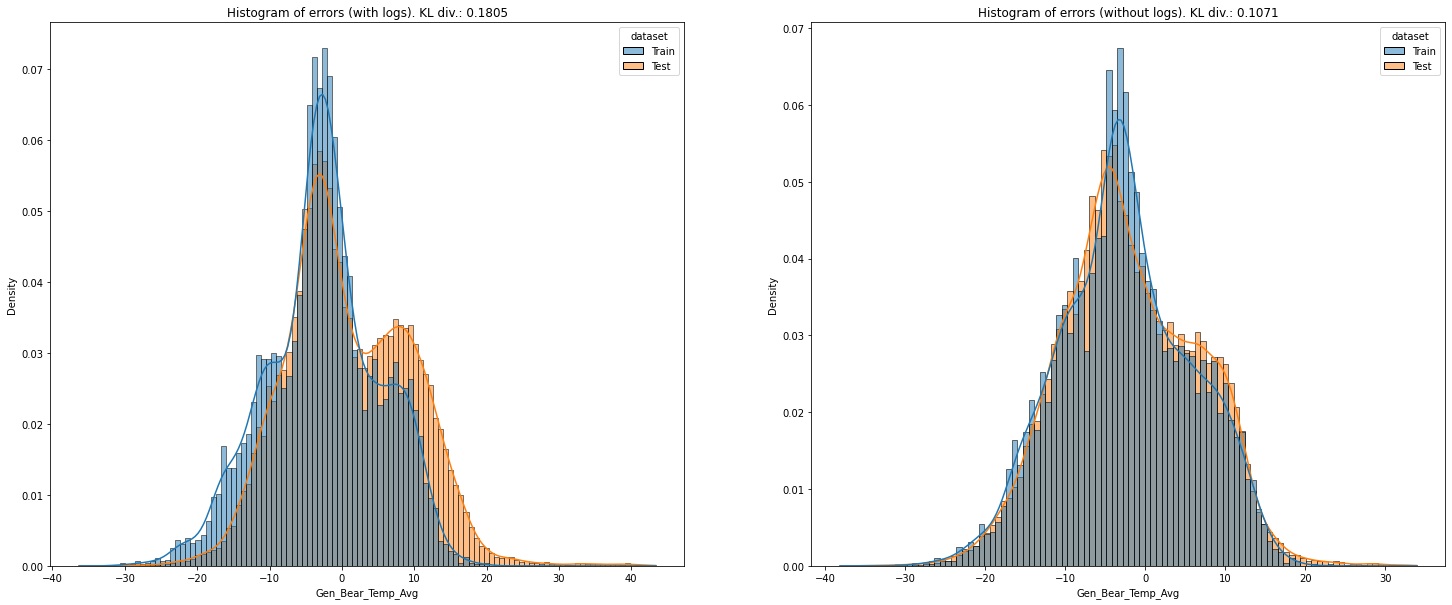

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(25,10))
errors_train_9['dataset'] = 'Train'
errors_test_9['dataset'] = 'Test'

errors_train_9_x['dataset'] = 'Train'
errors_test_9_x['dataset'] = 'Test'

sns.histplot(pd.concat([errors_train_9, errors_test_9], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[0])
sns.histplot(pd.concat([errors_train_9_x, errors_test_9_x], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[1])

kl_logs = kl_divergence(np.histogram(errors_train_9[target_feature], density=True)[0], np.histogram(errors_test_9[target_feature], density=True)[0])
kl_no_logs = kl_divergence(np.histogram(errors_train_9_x[target_feature], density=True)[0], np.histogram(errors_test_9_x[target_feature], density=True)[0])

axes[0].set_title('Histogram of errors (with logs). KL div.: {}'.format(round(kl_logs, 4)));
axes[1].set_title('Histogram of errors (without logs). KL div.: {}'.format(round(kl_no_logs, 4)));

Anomaly detection (assuming the error distribution is Gaussian for simplification)

In [ ]:
anomaly_threshold_9 = errors_train_9[target_feature].mean() + 3 * errors_train_9[target_feature].std()

Y_test_9['Anomaly'] = errors_test_9[target_feature] > anomaly_threshold_9
Y_train_9['Anomaly'] = errors_train_9[target_feature] > anomaly_threshold_9

anomaly_threshold_9_x = errors_train_9_x[target_feature].mean() + 3 * errors_train_9_x[target_feature].std()

Y_test_9_x['Anomaly'] = errors_test_9_x[target_feature] > anomaly_threshold_9_x
Y_train_9_x['Anomaly'] = errors_train_9_x[target_feature] > anomaly_threshold_9_x

print('Anomaly threshold (using log feature): ', anomaly_threshold_9)
print('Anomaly threshold (not using log feature): ', anomaly_threshold_9_x)

Anomaly threshold (using log feature):  20.741128902826905
Anomaly threshold (not using log feature):  21.933647016069372


Append relevant log warning message(s) from the previous 24 hours, if found, to data points labeled as anomaly

In [ ]:
Y_test_9 = append_relevant_log_warnings(Y_test_9, log_data_T09, 'Remark', target_feature, filter_by='Anomaly', max_distance='24H')
Y_test_9_x = append_relevant_log_warnings(Y_test_9_x, log_data_T09, 'Remark', target_feature, filter_by='Anomaly', max_distance='24H')

Label data points at time of gen bearing replacement

In [ ]:
Y_test_9.loc['2016-10-17 09:10:00+00', 'Anomaly'] = True
Y_test_9.loc['2016-10-17 09:10:00+00', 'logs_found'] = 'Generator bearings replaced'

Y_test_9_x.loc['2016-10-17 09:10:00+00', 'Anomaly'] = True
Y_test_9_x.loc['2016-10-17 09:10:00+00', 'logs_found'] = 'Generator bearings replaced'

#Add date column
Y_test_9['date'] = pd.to_datetime(Y_test_9.index.date)
Y_test_9_x['date'] = pd.to_datetime(Y_test_9_x.index.date)

Extract days where at least one anomaly was detected to visualize data

In [ ]:
#gt -> ground truth, pr -> predictions, x -> input features
gt_9 = Y_test_9[Y_test_9.date.isin(list(Y_test_9[Y_test_9['Anomaly']].index.date))].reset_index()
pr_9 = predictions_test_9[Y_test_9.date.isin(list(Y_test_9[Y_test_9['Anomaly']].index.date))].reset_index()
x_9 = X_test_9[Y_test_9.date.isin(list(Y_test_9[Y_test_9['Anomaly']].index.date))].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_9.loc[gt_9['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_9.loc[gt_9['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_9.loc[x_9['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

All anomalies detected by model_9 (NBM with log features) (click on img to zoom)

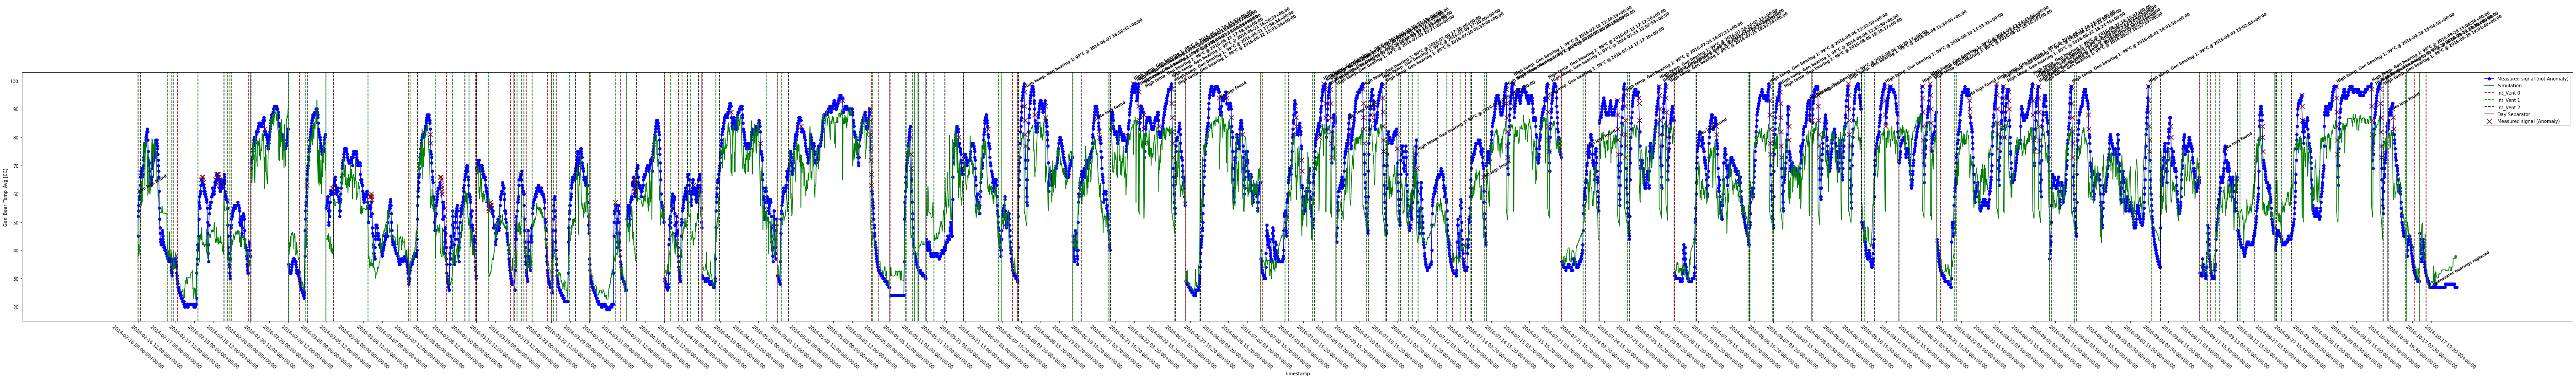

In [ ]:
plot_predicted_vs_true(pr_9, gt_9, target_feature, hue='Anomaly', figsize=(100,10))
plot_control_signals(x_9, 'Int_Vent')
plot_log_warnings(gt_9, 'Anomaly', 'logs_found', target_feature, 'Generator bearings replaced')

plt.xticks(range(0, gt_9.shape[0], 72), labels = gt_9['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

Anomalies detected by model_9 (NBM with log features) and not by model_9_x (NBM without log features)

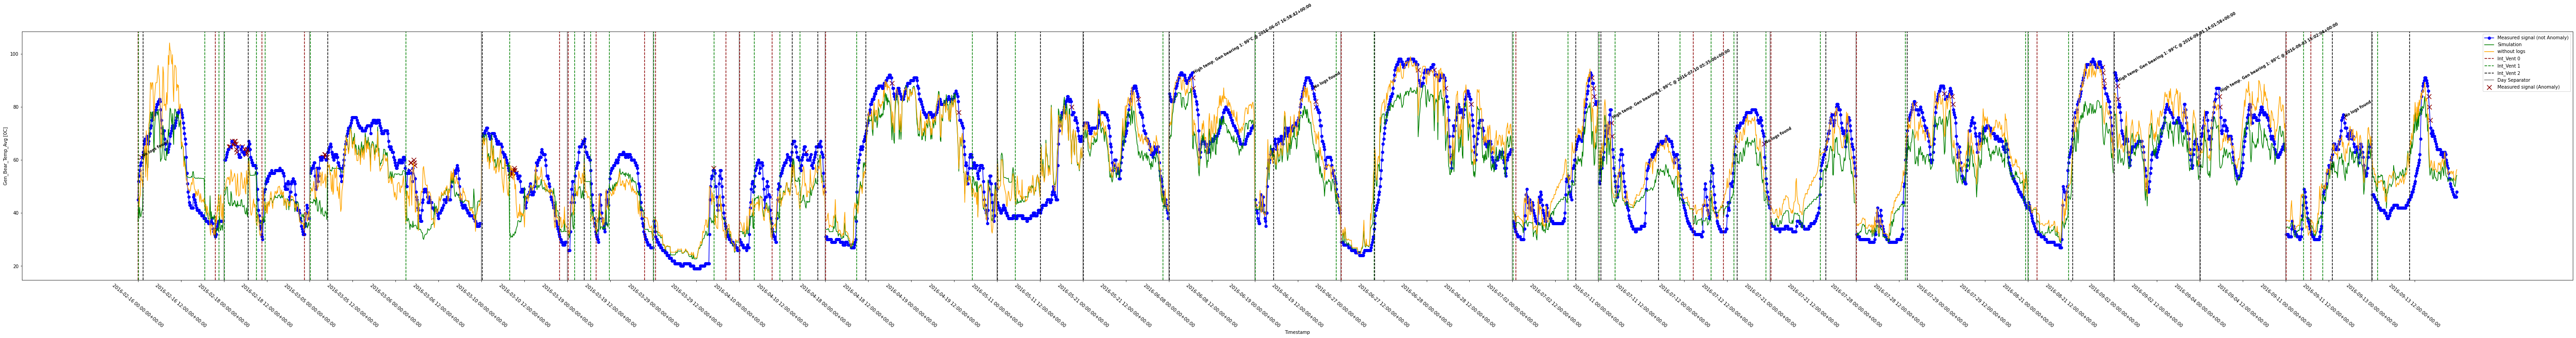

In [ ]:
ixes = (Y_test_9.date.isin(list(Y_test_9[Y_test_9['Anomaly']].index.date))) & ~(Y_test_9.date.isin(list(Y_test_9_x[Y_test_9_x['Anomaly']].index.date)))

gt_9 = Y_test_9[ixes].reset_index()
pr_9 = predictions_test_9[ixes].reset_index()
x_9 = X_test_9[ixes].reset_index()

pr_9_x = predictions_test_9_x[ixes].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_9.loc[gt_9['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_9.loc[gt_9['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_9.loc[x_9['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

plot_predicted_vs_true(pr_9, gt_9, target_feature, hue='Anomaly', figsize=(100,10))
plt.plot(pr_9_x.index, pr_9_x[target_feature], color='orange', label='without logs')
plot_control_signals(x_9, 'Int_Vent')
plot_log_warnings(gt_9, 'Anomaly', 'logs_found', target_feature, 'Generator bearings replaced')

plt.xticks(range(0, gt_9.shape[0], 72), labels = gt_9['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());


Anomalies detected by model_9_x (NBM without log features) and not by model_9 (NBM with log features)

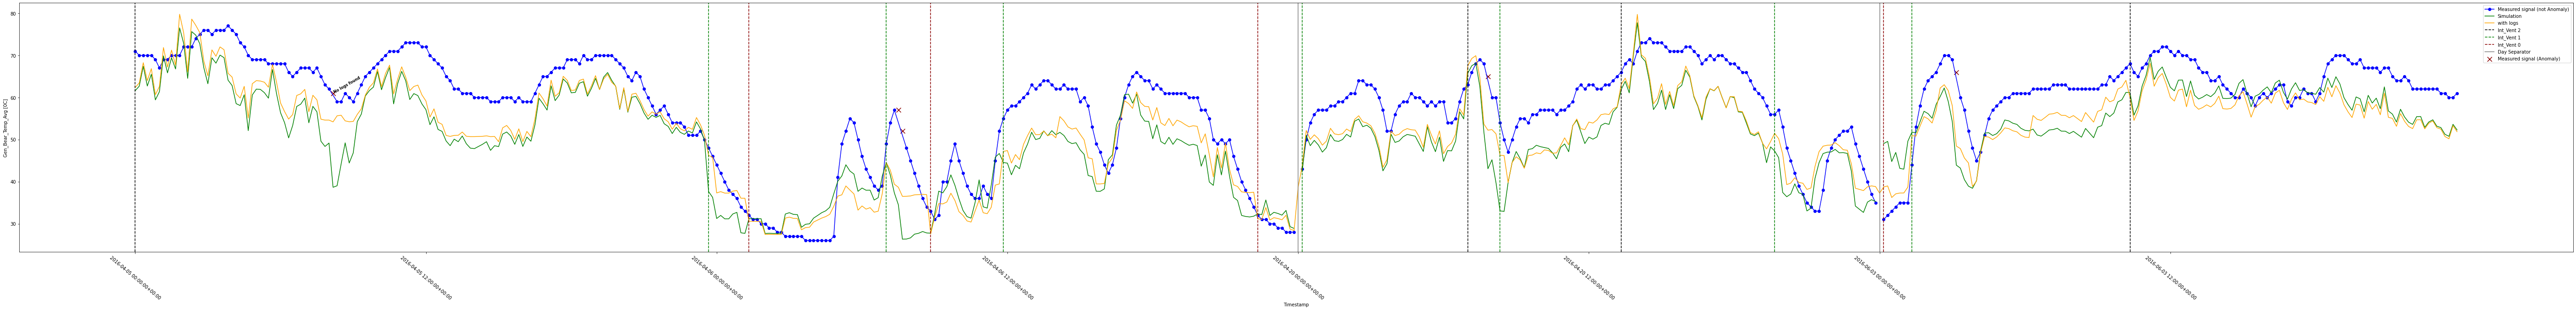

In [ ]:
ixes = (Y_test_9_x.date.isin(list(Y_test_9_x[Y_test_9_x['Anomaly']].index.date))) & ~(Y_test_9_x.date.isin(list(Y_test_9[Y_test_9['Anomaly']].index.date)))

gt_9_x = Y_test_9_x[ixes].reset_index()
pr_9_x = predictions_test_9_x[ixes].reset_index()
x_9_x = X_test_9[ixes].reset_index()

pr_9 = predictions_test_9[ixes].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_9_x.loc[gt_9_x['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_9_x.loc[gt_9_x['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_9_x.loc[x_9_x['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

plot_predicted_vs_true(pr_9_x, gt_9_x, target_feature, hue='Anomaly', figsize=(100,10))
plt.plot(pr_9.index, pr_9[target_feature], color='orange', label='with logs')
plot_control_signals(x_9_x, 'Int_Vent')
plot_log_warnings(gt_9_x, 'Anomaly', 'logs_found', target_feature, 'Generator bearings replaced')

plt.xticks(range(0, gt_9_x.shape[0], 72), labels = gt_9_x['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

In [ ]:
#====================================================================================================================================================

**NBM for T01(Healthy reference turbine)**

**Deep Learning**

In [ ]:
#Train with log features
dataset_1, X_train_1, Y_train_1, predictions_train_1, errors_train_1, X_test_1, Y_test_1, predictions_test_1, errors_test_1, model_1, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_feature, turbine_id='T01',
                         features=features_w_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 10)                70        
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
176/176 - 1s - loss: 0.0131 - 863ms/epoch - 5ms/step
Epoch 2/300
176/176 - 0s - loss: 0.0067 - 331ms/epoch - 2ms/step
Epoch 3/300
176/176 - 0s - loss: 0.0063 - 263ms/epoch - 1ms/step
Epoch 4/300
176/176 - 0s - loss: 0.0060 - 280ms/epoch - 2ms/step
Epoch 5/300
176/176 - 0s - loss: 0.0056 - 

In [ ]:
#Train without log features
dataset_1_x, X_train_1_x, Y_train_1_x, predictions_train_1_x, errors_train_1_x, X_test_1_x, Y_test_1_x, predictions_test_1_x, errors_test_1_x, model_1_x, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_feature, turbine_id='T01',
                         features=features_wout_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 10)                50        
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
176/176 - 1s - loss: 0.1363 - 789ms/epoch - 4ms/step
Epoch 2/300
176/176 - 0s - loss: 0.0093 - 323ms/epoch - 2ms/step
Epoch 3/300
176/176 - 0s - loss: 0.0080 - 321ms/epoch - 2ms/step
Epoch 4/300
176/176 - 0s - loss: 0.0076 - 301ms/epoch - 2ms/step
Epoch 5/300
176/176 - 0s - loss: 0.0072 - 

Distribution of errors

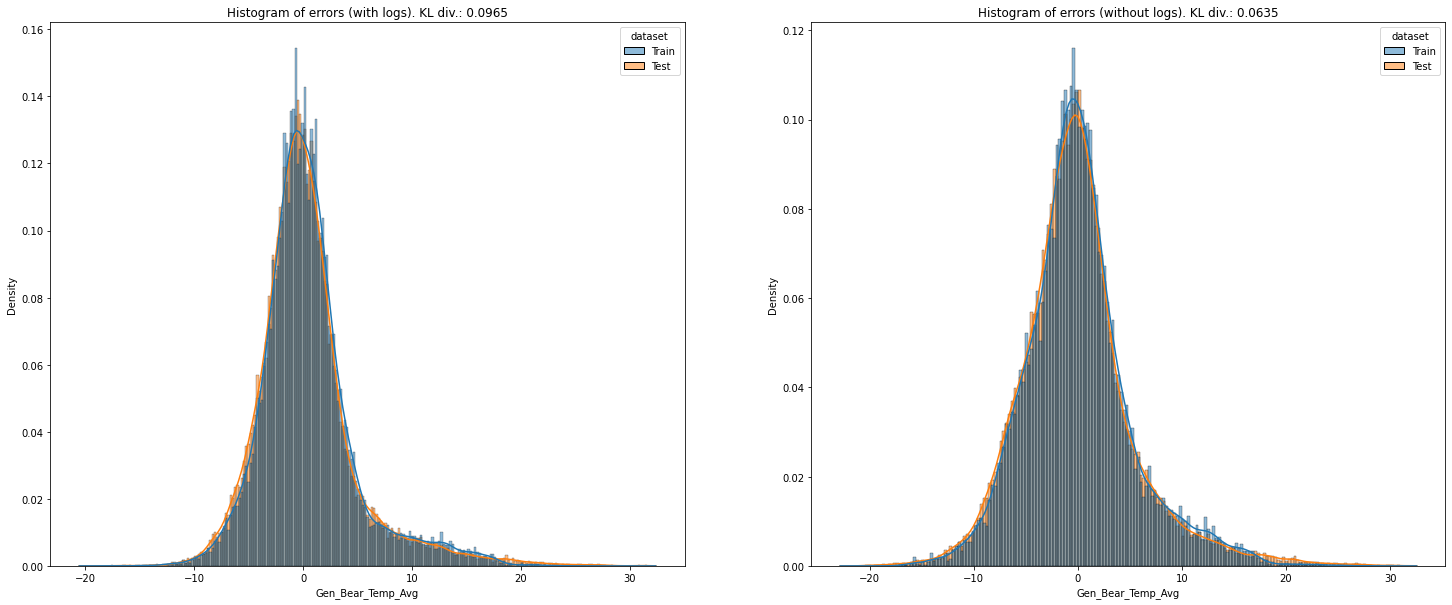

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(25,10))
errors_train_1['dataset'] = 'Train'
errors_test_1['dataset'] = 'Test'

errors_train_1_x['dataset'] = 'Train'
errors_test_1_x['dataset'] = 'Test'

sns.histplot(pd.concat([errors_train_1, errors_test_1], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[0])
sns.histplot(pd.concat([errors_train_1_x, errors_test_1_x], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[1])

kl_logs = kl_divergence(np.histogram(errors_train_1[target_feature], density=True)[0], np.histogram(errors_test_1[target_feature], density=True)[0])
kl_no_logs = kl_divergence(np.histogram(errors_train_1_x[target_feature], density=True)[0], np.histogram(errors_test_1_x[target_feature], density=True)[0])

axes[0].set_title('Histogram of errors (with logs). KL div.: {}'.format(round(kl_logs, 4)));
axes[1].set_title('Histogram of errors (without logs). KL div.: {}'.format(round(kl_no_logs, 4)));

Anomaly detection (assuming the error distribution is Gaussian for simplification)

In [ ]:
anomaly_threshold_1 = errors_train_1[target_feature].mean() + 3 * errors_train_1[target_feature].std()

Y_test_1['Anomaly'] = errors_test_1[target_feature] > anomaly_threshold_1
Y_train_1['Anomaly'] = errors_train_1[target_feature] > anomaly_threshold_1

anomaly_threshold_1_x = errors_train_1_x[target_feature].mean() + 3 * errors_train_1_x[target_feature].std()

Y_test_1_x['Anomaly'] = errors_test_1_x[target_feature] > anomaly_threshold_1_x
Y_train_1_x['Anomaly'] = errors_train_1_x[target_feature] > anomaly_threshold_1_x

print('Anomaly threshold (using log feature): ', anomaly_threshold_1)
print('Anomaly threshold (not using log feature): ', anomaly_threshold_1_x)

Anomaly threshold (using log feature):  13.488365614075231
Anomaly threshold (not using log feature):  15.351098106621423


Append relevant log warning message(s) from the previous 24 hours, if found, to data points labeled as anomaly

In [ ]:
Y_test_1 = append_relevant_log_warnings(Y_test_1, log_data_T09, 'Remark', target_feature, filter_by='Anomaly', max_distance='24H')
Y_test_1_x = append_relevant_log_warnings(Y_test_1_x, log_data_T09, 'Remark', target_feature, filter_by='Anomaly', max_distance='24H')

Label data points at time of gen bearing replacement

In [ ]:
# Y_test_1.loc['2016-10-17 09:10:00+00', 'Anomaly'] = True
# Y_test_1.loc['2016-10-17 09:10:00+00', 'logs_found'] = 'Generator bearings replaced'

# Y_test_1_x.loc['2016-10-17 09:10:00+00', 'Anomaly'] = True
# Y_test_1_x.loc['2016-10-17 09:10:00+00', 'logs_found'] = 'Generator bearings replaced'

# #Add date column
# Y_test_1['date'] = pd.to_datetime(Y_test_1.index.date)
# Y_test_1_x['date'] = pd.to_datetime(Y_test_1_x.index.date)

Extract days where at least one anomaly was detected to visualize data

In [ ]:
#gt -> ground truth, pr -> predictions, x -> input features
gt_1 = Y_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))].reset_index()
pr_1 = predictions_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))].reset_index()
x_1 = X_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1.loc[x_1['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


All anomalies detected by model_1 (NBM with log features) (click on img to zoom)

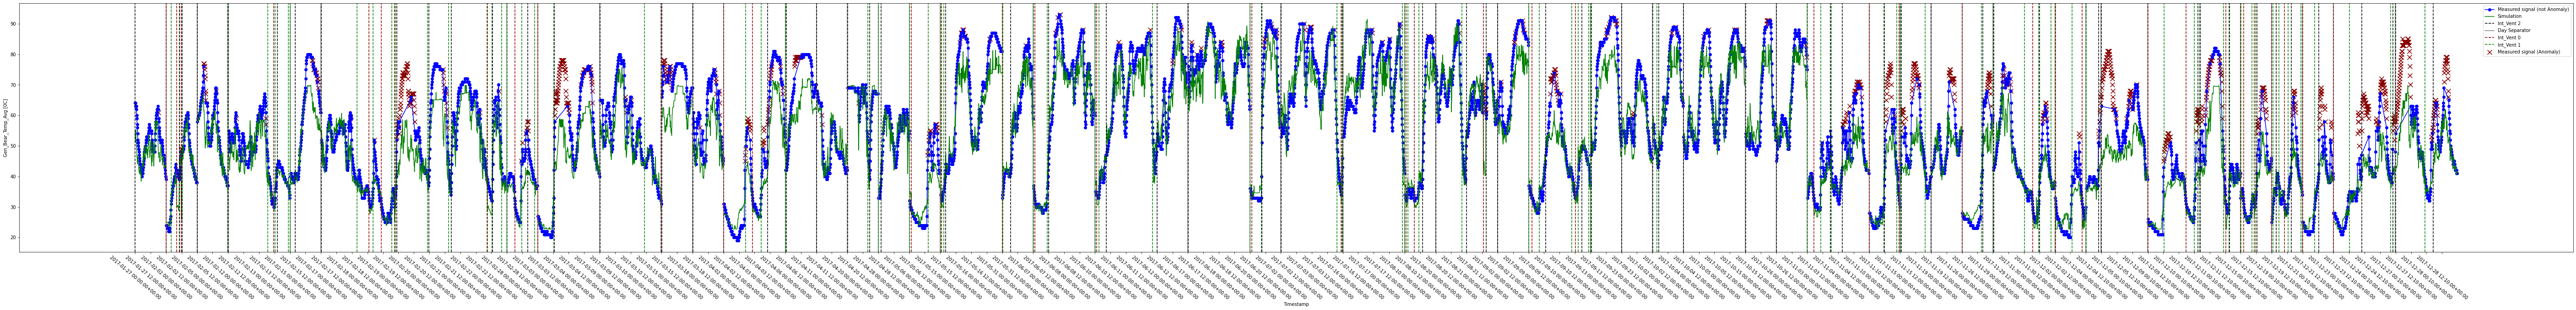

In [ ]:
plot_predicted_vs_true(pr_1, gt_1, target_feature, hue='Anomaly', figsize=(100,10))
plot_control_signals(x_1, 'Int_Vent')

plt.xticks(range(0, gt_1.shape[0], 72), labels = gt_1['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

Anomalies detected by model_1 (NBM with log features) and not by model_1_x (NBM without log features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


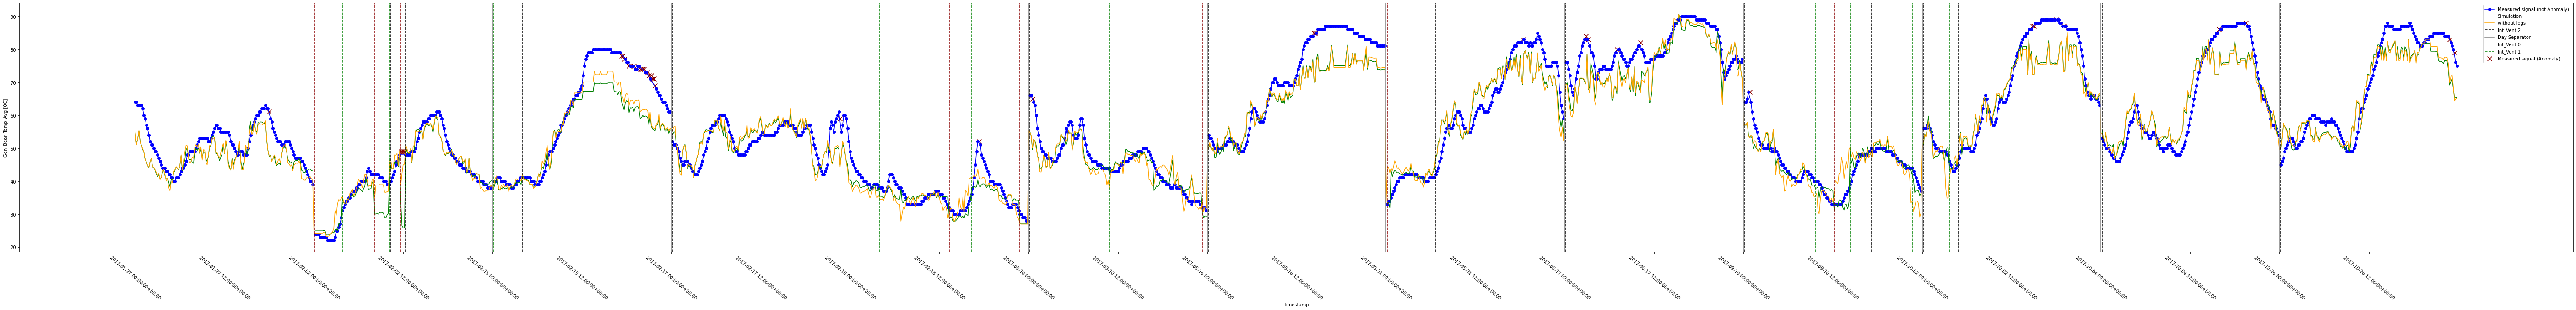

In [ ]:
ixes = (Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))) & ~(Y_test_1.date.isin(list(Y_test_1_x[Y_test_1_x['Anomaly']].index.date)))

gt_1 = Y_test_1[ixes].reset_index()
pr_1 = predictions_test_1[ixes].reset_index()
x_1 = X_test_1[ixes].reset_index()

pr_1_x = predictions_test_1_x[ixes].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1.loc[x_1['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

plot_predicted_vs_true(pr_1, gt_1, target_feature, hue='Anomaly', figsize=(100,10))
plt.plot(pr_1_x.index, pr_1_x[target_feature], color='orange', label='without logs')
plot_control_signals(x_1, 'Int_Vent')

plt.xticks(range(0, gt_1.shape[0], 72), labels = gt_1['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

Anomalies detected by model_1_x (NBM without log features) and not by model_1 (NBM with log features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


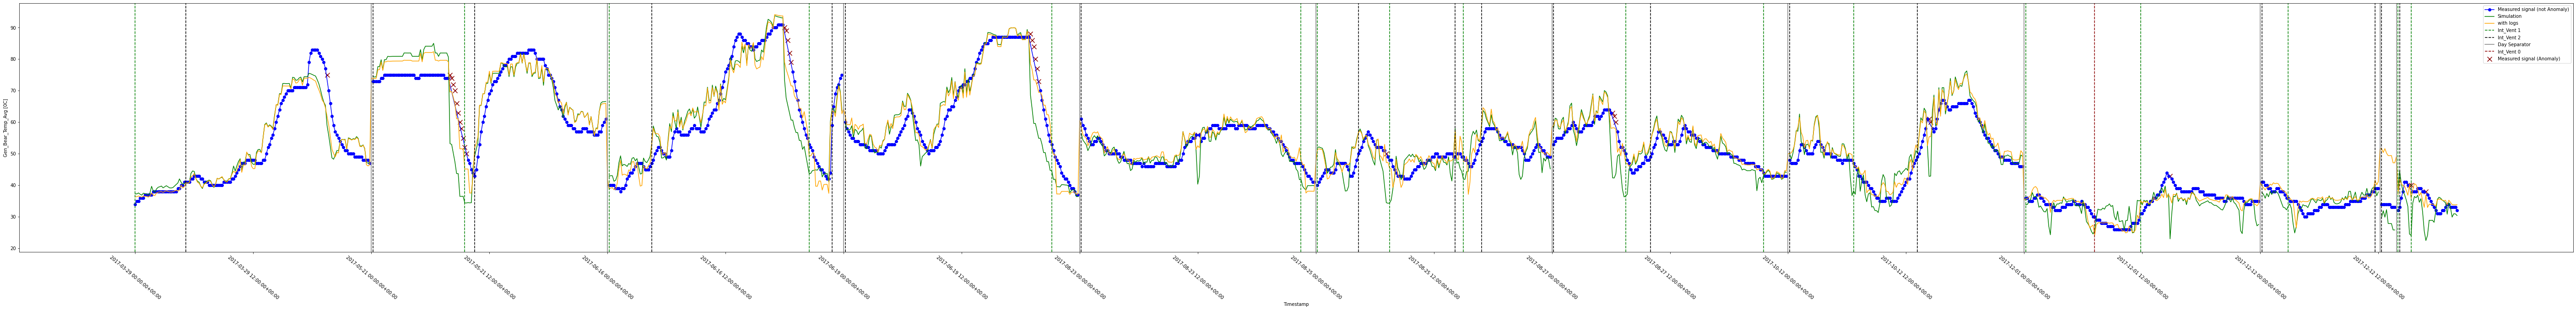

In [ ]:
ixes = (Y_test_1_x.date.isin(list(Y_test_1_x[Y_test_1_x['Anomaly']].index.date))) & ~(Y_test_1_x.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date)))

gt_1_x = Y_test_1_x[ixes].reset_index()
pr_1_x = predictions_test_1_x[ixes].reset_index()
x_1_x = X_test_1[ixes].reset_index()

pr_1 = predictions_test_1[ixes].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1_x.loc[gt_1_x['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1_x.loc[gt_1_x['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1_x.loc[x_1_x['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

plot_predicted_vs_true(pr_1_x, gt_1_x, target_feature, hue='Anomaly', figsize=(100,10))
plt.plot(pr_1.index, pr_1[target_feature], color='orange', label='with logs')
plot_control_signals(x_1_x, 'Int_Vent')

plt.xticks(range(0, gt_1_x.shape[0], 72), labels = gt_1_x['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());